In [3]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from src.pipeline import find_flux, find_noise_square
import warnings
import pandas as pd
from astropy.wcs import WCS
warnings.filterwarnings("ignore")

In [43]:
# Set location of the data
location = '/net/vdesk/data2/deklerk/GAAP_data'

# Set the field
field = '53.0_-28.0'

# Set the aperture size (pixels)
aperture_size = 12

In [29]:
with fits.open(f'/net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/{field}/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits') as hdul:
    hdul.info()
    cat = Table(hdul[1].data)

ra_reference = cat['RIGHT_ASCENSION']
dec_reference = cat['DECLINATION']

Filename: /net/ketelmeer/data2/kuijken/GAAP/EuclidRubinData/53.0_-28.0/EUC_MER_FINAL-CAT_TILE102044185-530716_20250729T003328.783247Z_00.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  EUC_MER__FINAL_CATALOG    1 BinTableHDU   1464   96164R x 470C   [K, D, D, D, D, K, K, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E,

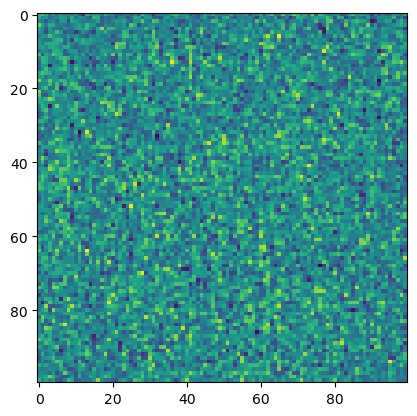

In [10]:
files = glob.glob(f'{location}/{field}/u_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[1]
    y0_rubin, x0_rubin, y1_rubin, x1_rubin = find_noise_square(hdul[1].data, 100)
    plt.imshow(hdul[1].data[y0_rubin:y1_rubin, x0_rubin:x1_rubin])
    plt.show()

In [11]:
catalog = Table.read(f'{location}/{field}/VIS.cat', format='fits', hdu=2)
files = glob.glob(f'{location}/{field}/VIS_*.fits')
image_file = [file for file in files if not file.endswith("psf.fits")][0]
with fits.open(image_file) as hdul:
    hdu = hdul[0]
    # y0_euclid, x0_euclid, y1_euclid, x1_euclid = find_noise_square(hdul[0].data, 200)
    # plt.imshow(hdul[0].data[y0_euclid:y1_euclid, x0_euclid:x1_euclid])
    # plt.imshow()

reference_wcs = WCS(hdu.header)
ra_reference, dec_reference = reference_wcs.wcs_pix2world(catalog['X_IMAGE'], catalog['Y_IMAGE'], 0, ra_dec_order=True)

In [48]:
fluxes = {}
sigmas = {}
rubin_filters = ['g', 'r', 'i']
euclid_filters = ['VIS', 'DES-G', 'DES-R', 'DES-I', 'NIR-Y', 'NIR-J', 'NIR-H']

fluxes['ra'] = ra_reference
fluxes['dec'] = dec_reference

# rubin_filters = []
for filter in rubin_filters:
    files = glob.glob(f'{location}/{field}/{filter}_*.fits')
    image_file = [file for file in files if not file.endswith("psf.fits")][0]
    psf_file = [file for file in files if file.endswith("psf.fits")][0]
    fluxes[filter], sigmas[filter] = find_flux(image_file, "Rubin", aperture_size, ra_reference, dec_reference, psf_path=psf_file, correlated=None, noise_x0=x0_rubin, noise_x1=x1_rubin, noise_y0=y0_rubin, noise_y1=y1_rubin)

# euclid_filters = ['DES-G', 'DES-R', 'DES-I']
# for filter in euclid_filters:
#     files = glob.glob(f'{location}/{field}/{filter}_*.fits')
#     image_file = [file for file in files if not file.endswith("psf.fits")][0]
#     fluxes[filter], sigmas[filter] = find_flux(image_file, "Euclid", 8, ra_reference, dec_reference, catalog_path=f'{location}/{field}/{filter}.cat', tilesize = 1200)

Analyzing image
Analyzing image
Analyzing image


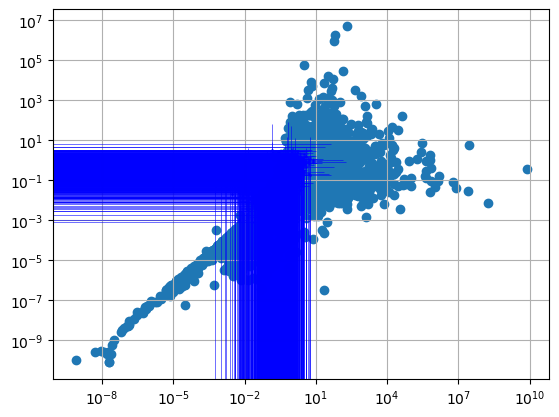

82556 13592


In [56]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_1] / fluxes[filter_1])**2 +
        (sigmas[filter_2] / fluxes[filter_2])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_3] / fluxes[filter_3])**2 +
        (sigmas[filter_4] / fluxes[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < np.inf)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    gaap_error = xerr**2 + yerr**2
    # plt.show()
    # Plot
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    x_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    )

    mask = (xerr**2 + yerr**2 < np.inf)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    euclid_error = xerr**2 + yerr**2
    # plt.errorbar(
    #     x_color[mask], y_color[mask],
    #     xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    #     fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8, label='EUCLID MER'
    # )

    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-3, 4)
    # plt.ylim(-2.5, 4)
    # plt.legend()
    # plt.show()
    # plt.boxplot([gaap_error, euclid_error], flierprops=dict(marker=''))
    plt.scatter(euclid_error, gaap_error)
    plt.loglog()
    plt.show()
    print(np.sum(gaap_error>euclid_error), np.sum(gaap_error<euclid_error))

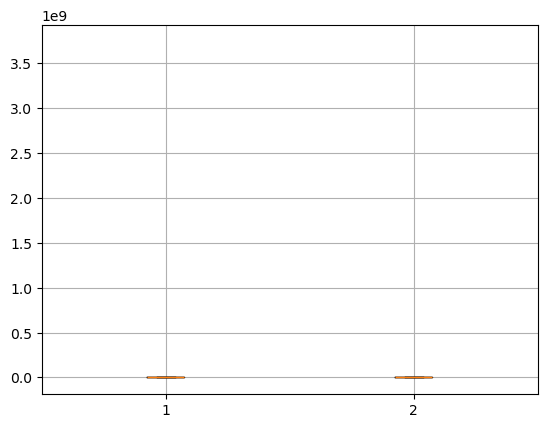

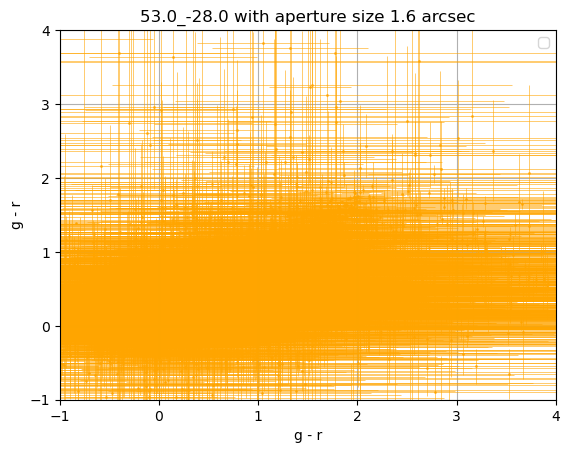

13627 82527


In [ ]:
filter_1 = 'g'   # e.g., master_table column name
filter_2 = 'r'
filter_3 = 'r'
filter_4 = 'i'

plot_error = True

with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    # Compute colors from master_table fluxes
    # x_color = -2.5 * np.log10(fluxes[filter_1] / fluxes[filter_2])
    y_color = -2.5 * np.log10(fluxes[filter_3] / fluxes[filter_4])

    # Compute errors from sigma dictionary
    # xerr = 2.5 / np.log(10) * np.sqrt(
    #     (sigmas[filter_1] / fluxes[filter_1])**2 +
    #     (sigmas[filter_2] / fluxes[filter_2])**2
    # )
    yerr = 2.5 / np.log(10) * np.sqrt(
        (sigmas[filter_3] / fluxes[filter_3])**2 +
        (sigmas[filter_4] / fluxes[filter_4])**2
    )

    # Optional: filter points with very large errors
    mask = (xerr**2 + yerr**2 < np.inf)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    gaap_error = xerr[mask]**2 + yerr[mask]**2
    # plt.show()
    # Plot
    # plt.errorbar(
    #     x_color[mask], y_color[mask],
    #     xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
    #     fmt='o', c='b', ms=1, elinewidth=0.5, alpha=0.8, label='GAAP'
    # )
    # plt.title(f'{field} with aperture size {8/5} arcsec')
    # plt.xlabel(f'{filter_1} - {filter_2}')
    # plt.ylabel(f'{filter_3} - {filter_4}')
    # plt.xlim(-1, 4)
    # plt.ylim(-2.5, 2.5)
    # plt.show()
    x_color = -2.5 * np.log10(cat['FLUX_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])
    # y_color = -2.5 * np.log10(cat['FLUX_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])

    # Compute errors from sigma dictionary
    xerr = 2.5 / np.log(10) * np.sqrt(
        (cat['FLUXERR_G_EXT_DECAM_2FWHM_APER'] / cat['FLUX_G_EXT_DECAM_2FWHM_APER'])**2 +
        (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2
    )
    # yerr = 2.5 / np.log(10) * np.sqrt(
    #     (cat['FLUXERR_R_EXT_DECAM_2FWHM_APER'] / cat['FLUX_R_EXT_DECAM_2FWHM_APER'])**2 +
    #     (cat['FLUXERR_I_EXT_DECAM_2FWHM_APER'] / cat['FLUX_I_EXT_DECAM_2FWHM_APER'])**2
    # )

    mask = (xerr**2 + yerr**2 < np.inf)
    new_mask = np.isfinite(xerr) &  np.isfinite(yerr)
    euclid_error = xerr[mask]**2 + yerr[mask]**2
    plt.boxplot([gaap_error, euclid_error], flierprops=dict(marker=''))
    plt.show()
    plt.errorbar(
        x_color[mask], y_color[mask],
        xerr=xerr[mask] * plot_error, yerr=yerr[mask] * plot_error,
        fmt='o', c='orange', ms=1, elinewidth=0.5, alpha=0.8)

    plt.title(f'{field} with aperture size {8/5} arcsec')
    plt.xlabel(f'{filter_1} - {filter_2}')
    plt.ylabel(f'{filter_3} - {filter_4}')
    plt.xlim(-1, 4)
    plt.ylim(-1, 4)
    plt.legend()
    plt.show()
    # plt.scatter(xerr, yerr)